In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import regex as re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Funciones para armar el dataset

In [2]:
import os
def get_hashtags_text(x):
    if pd.notna(x) and 'hashtags' in x and x['hashtags']:
        hashtags = x['hashtags']
        hashtags_text = [ht['text'] for ht in hashtags]
        return hashtags_text
    else:
        return None

def get_urls(x):
    if pd.notna(x) and 'urls' in x and x['urls']:
        return True
    return False


def get_user_location(x):
    if pd.notna(x) and 'location' in x:
        return x['location']
    else:
        return None


def load_json(file_path):
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                if 'retweeted_status' in data and data['retweeted_status'] != None:
                    data = data['retweeted_status']
                datos_json.append(data)

        df = pd.DataFrame(datos_json)

        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)
        
        # Asignar 0 a las columnas 'reply_count' y 'quote_count' si no existen
        df_new['reply_count'] = df.get('reply_count', 0)
        df_new['quote_count'] = df.get('quote_count', 0)

        # Verificar si hay al menos una imagen en el JSON
        has_image = []
        for i in range(len(df)):
            try:
                extended_entities = df['extended_entities'][i]
                if 'media' in extended_entities and len(extended_entities['media']) > 0:
                    has_image.append(True)
                else:
                    has_image.append(False)
            except (KeyError, TypeError):
                has_image.append(False)

        df_new['has_image'] = has_image

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new


def load_jsons_from_folder(folder_path):
    df_all = pd.DataFrame()

    try:
        # Obtener la lista de archivos en la carpeta
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(folder_path, file_name)
            df = load_json(file_path)

            # Extraer el nombre del archivo sin "_final_data.json"
            json_name = file_name.replace('_final_data.json', '')

            # Agregar columna con el nombre del JSON
            df['json_name'] = json_name

            # Concatenar el DataFrame al DataFrame total
            df_all = pd.concat([df_all, df], ignore_index=True)

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_all

def read_tsv_folder(folder_path):
    df_combined = pd.DataFrame()  # DataFrame combinado para almacenar los datos de todos los archivos TSV

    # Obtener la lista de archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Leer cada archivo TSV y combinar los datos en el DataFrame combinado
    for file_name in file_list:
        if file_name.endswith(".tsv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep="\t")
            df_combined = pd.concat([df_combined, df], ignore_index=True)

    return df_combined



In [3]:
# Filtrar las filas sin imágenes
#df_without_images = harvey_json.loc[harvey_json['has_image'] == 0]
#df_without_images

df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")

#df_tsv

In [4]:
df_json[df_json["favorite_count"]>0]

,id,lang,text,favorite_count,retweet_count,possibly_sensitive,created_at,is_quote_status,entities_hashtags_text,entities_urls,user_location,reply_count,quote_count,has_image,json_name
1,917787635946524674,en,Wildfires raging through Northern California a...,7,5,False,Tue Oct 10 16:23:18 +0000 2017,False,None,True,None,0.0,4.0,True,california_wildfires
2,917500054742605829,en,"PLS SHARE: We’re capturing wildfire response, ...",289,479,False,Mon Oct 09 21:20:34 +0000 2017,False,None,True,"Sacramento, California",9.0,25.0,True,california_wildfires
3,917623252264062976,en,California's raging wildfires as you've never ...,228,216,False,Tue Oct 10 05:30:06 +0000 2017,False,None,True,None,19.0,18.0,True,california_wildfires
6,917715928271507456,en,Southern California fire shrouds Disneyland An...,133,76,False,Tue Oct 10 11:38:22 +0000 2017,False,None,True,U.S.A.,25.0,7.0,True,california_wildfires
8,917433167014920192,en,California wildfires destroy more than 50 stru...,1,2,False,Mon Oct 09 16:54:46 +0000 2017,False,[KAKEnews],True,"Wichita, Kansas",0.0,0.0,True,california_wildfires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15839,867784220130672641,en,Arch And Texture\nantonio mora https://t.co/PK...,5,4,False,Thu May 25 16:47:35 +0000 2017,False,None,False,None,0.0,0.0,True,srilanka_floods
15889,869952041698811904,en,Please support my GoFundMe campaign: https://t...,1,1,False,Wed May 31 16:21:44 +0000 2017,False,None,True,"New Mexico, USA",0.0,0.0,True,srilanka_floods
15966,869096735427014656,en,Hat's off to this Man Palitha Thewarapperuma \...,7,4,False,Mon May 29 07:43:03 +0000 2017,False,"[Respect, FloodSL, lka, greatpeople]",False,Sri Lanka යකෝ,0.0,0.0,True,srilanka_floods
15985,847154724109533190,en,Portrait double exposure ❤️⭐️❤️⭐️❤️Antonio Mor...,186,123,False,Wed Mar 29 18:33:20 +0000 2017,False,None,False,"Rhône-Alpes, France",0.0,0.0,True,srilanka_floods


### Merge datasets

In [5]:
df = pd.merge(df_json, df_tsv[['tweet_id', 'text_info', 'text_info_conf', 'text_human', 'text_human_conf']],
                    left_on='id', right_on='tweet_id', how='left')
df.drop('tweet_id',axis=1,inplace=True)
df_con_nan = df.copy()
df =  df[df['text_human'].notna()]
print(df.shape)
df_con_nan.T



(15477, 19)


,0,1,2,3,4,5,6,7,8,9,...,17622,17623,17624,17625,17626,17627,17628,17629,17630,17631
id,917791130590183424,917787635946524674,917500054742605829,917623252264062976,917792930315821057,917792147700465664,917715928271507456,917794232160661505,917433167014920192,917793736918216706,...,881612317317836800,881612317317836800,881612317317836800,881612317317836800,881632991776301056,881714673157980160,881749861871362049,881770990556131328,881807298930368513,869578299487404032
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,PHOTOS: Deadly wildfires rage in California ht...,Wildfires raging through Northern California a...,"PLS SHARE: We’re capturing wildfire response, ...",California's raging wildfires as you've never ...,Mass Evacuations in California as Wildfires Ki...,Wildfires Threaten California’s First Legal Ca...,Southern California fire shrouds Disneyland An...,At Least 11 Dead and 100 Missing as Wildfires ...,California wildfires destroy more than 50 stru...,California wildfire. ὡ4 https://t.co/a8oD5rkDdI,...,"Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...",https://t.co/7VqAlUWTUO My #wine tip for this ...,Get to mora and try the whole menu https://t.c...,"Mirka Mora (b.1928), noted French-born Austral...","@PaulMalignaggi Lol What u on about, Sergio Mo...",#Cameroon : 4 #female suicide #Bombers kill 1 ...,it happened during the visit of #CycloneMora o...
favorite_count,0,7,289,228,0,0,133,0,1,0,...,0,0,0,0,0,0,0,0,0,0
retweet_count,0,5,479,216,0,0,76,0,2,0,...,0,0,0,0,0,0,0,0,0,1
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Tue Oct 10 16:37:11 +0000 2017,Tue Oct 10 16:23:18 +0000 2017,Mon Oct 09 21:20:34 +0000 2017,Tue Oct 10 05:30:06 +0000 2017,Tue Oct 10 16:44:21 +0000 2017,Tue Oct 10 16:41:14 +0000 2017,Tue Oct 10 11:38:22 +0000 2017,Tue Oct 10 16:49:31 +0000 2017,Mon Oct 09 16:54:46 +0000 2017,Tue Oct 10 16:47:33 +0000 2017,...,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 21:57:39 +0000 2017,Mon Jul 03 03:22:14 +0000 2017,Mon Jul 03 05:42:03 +0000 2017,Mon Jul 03 07:06:01 +0000 2017,Mon Jul 03 09:30:17 +0000 2017,Tue May 30 15:36:37 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,None,None,None,[CaliforniaWildfires],None,None,None,[KAKEnews],None,...,None,None,None,None,"[wine, weekend]",None,[womensart],None,"[Cameroon, female, Bombers]",[CycloneMora]
entities_urls,True,True,True,True,True,True,True,False,True,False,...,False,False,False,False,True,False,False,False,True,False


In [6]:

df.sort_values(by=["favorite_count"],ascending=False).T

,9065,6444,0,11888,11876,11877,11878,11879,11880,11881,...,6010,6012,6013,6014,6015,6017,6018,6019,6022,17630
id,905996704020922368,906635330618580997,917791130590183424,913834813974568961,913804552289255424,913804552289255424,913805227161260033,913808304069120003,913810789131276290,913814207958802433,...,905647123542155266,905647325434937344,905647416879177728,905647417168498688,905647457337466880,905647642205593601,905647710077763586,905647759050420225,905647841841864704,881807298930368513
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,Fossil fuel companies should pay for the damag...,Are Irma and Harvey God’s Punishment for Elect...,PHOTOS: Deadly wildfires rage in California ht...,Students spreading awareness about Hurricane M...,#CBP drives supplies from @HoustonTX to @CBPFl...,#CBP drives supplies from @HoustonTX to @CBPFl...,San Juan mayor outraged after DHS chief calls ...,Banana plantations flooded by Maria https://t....,Just one more hour! Stop by any of these locat...,PR's Monkey Island Hit by Maria https://t.co/i...,...,your girl isn't home and you walk in on hurric...,"Europe Edition: Hurricane Irma, Hungary, U.S. ...",Hurricane Irma on collision course with Florid...,"Hurricane Irma: Residential trash, recycling p...",AMS Opens Camping Facilities For Hurricane Irm...,VIDEO: Early Reports from Barbuda Survivors of...,SEVERE STORM THREAT for rest of the night. Ra...,*ISLAMIC SOCIETY OF TAMPA BAY AREA WILL OPEN I...,Harrowing footage shows plane flying through H...,#Cameroon : 4 #female suicide #Bombers kill 1 ...
favorite_count,525,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retweet_count,212,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Fri Sep 08 03:30:21 +0000 2017,Sat Sep 09 21:48:01 +0000 2017,Tue Oct 10 16:37:11 +0000 2017,Fri Sep 29 18:36:12 +0000 2017,Fri Sep 29 16:35:57 +0000 2017,Fri Sep 29 16:35:57 +0000 2017,Fri Sep 29 16:38:38 +0000 2017,Fri Sep 29 16:50:52 +0000 2017,Fri Sep 29 17:00:44 +0000 2017,Fri Sep 29 17:14:19 +0000 2017,...,Thu Sep 07 04:21:15 +0000 2017,Thu Sep 07 04:22:03 +0000 2017,Thu Sep 07 04:22:24 +0000 2017,Thu Sep 07 04:22:25 +0000 2017,Thu Sep 07 04:22:34 +0000 2017,Thu Sep 07 04:23:18 +0000 2017,Thu Sep 07 04:23:34 +0000 2017,Thu Sep 07 04:23:46 +0000 2017,Thu Sep 07 04:24:06 +0000 2017,Mon Jul 03 09:30:17 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,None,None,[WoodlandsPride],"[CBP, HurricaneMaria]","[CBP, HurricaneMaria]",None,None,None,None,...,None,None,[breakingnews],None,None,None,"[wx, irma, storm, Hurricane, rain, flood]",None,None,"[Cameroon, female, Bombers]"
entities_urls,True,True,True,False,False,False,False,True,False,True,...,False,True,True,True,True,True,True,False,True,True


### Exploración de los datos

In [67]:
summary = df.describe()
summary

,id,favorite_count,retweet_count,reply_count,quote_count,text_info_conf,text_human_conf
count,1.547700e+04,15477.000000,15477.000000,15259.000000,15260.000000,15477.000000,15477.000000
mean,9.108053e+17,0.035472,0.014667,0.012976,0.006881,0.798199,0.798199
std,1.150900e+16,4.224428,1.706450,1.547251,0.833952,0.201253,0.201253
min,8.699501e+17,0.000000,0.000000,0.000000,0.000000,0.257800,0.257800
25%,9.075860e+17,0.000000,0.000000,0.000000,0.000000,0.660800,0.660800
50%,9.101684e+17,0.000000,0.000000,0.000000,0.000000,0.708800,0.708800
75%,9.162843e+17,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.320276e+17,525.000000,212.000000,191.000000,103.000000,1.000000,1.000000


In [68]:
# select only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# select only non-numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

boolean_columns = df.select_dtypes(include=['bool']).columns.tolist()

print(numerical_columns)

print(categorical_columns)

print(boolean_columns)

['id', 'favorite_count', 'retweet_count', 'reply_count', 'quote_count', 'text_info_conf', 'text_human_conf']
['lang', 'text', 'created_at', 'is_quote_status', 'entities_hashtags_text', 'user_location', 'json_name', 'text_info', 'text_human']
['possibly_sensitive', 'entities_urls', 'has_image']


#### Se revisa si hay ids repetidos

In [69]:
print(df["id"].shape)
df["id"].value_counts()

(15477,)


id
909754460745945088    8
908525619037732865    4
906689052132368384    4
869972354004393987    4
912204795427123200    4
                     ..
905647896330084353    1
905652347296198656    1
905652947534585857    1
905653129298849792    1
881807298930368513    1
Name: count, Length: 13899, dtype: int64

In [70]:
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df.shape)
df["id"].value_counts()

(13899, 19)


id
917791130590183424    1
913526987720921088    1
913501170173337600    1
913503821971603457    1
913507924030492672    1
                     ..
910156535011135488    1
910159570353491969    1
910160558011318279    1
910160788849008640    1
881807298930368513    1
Name: count, Length: 13899, dtype: int64

Con los datos no duplicados, se revisa la variedad de ciertas columnas. Si estás columnas solo retornan un único valor, se eliminan por redundancia.


In [71]:
language = df["lang"]

wa = []

for i in language:
    if i not in wa:
        wa.append(i)

print(wa)

['en']


#### Contando valores 

In [72]:


count_retweet_not_zero = len(df[(df['retweet_count'] >= 1)])
count_favorite_not_zero = len(df[(df['favorite_count'] >= 1)])
reply_counts = len(df[(df['reply_count'] >= 1)])
quote_counts = len(df[(df['quote_count'] >= 1)])

# Contar la cantidad de tweets con retweet_count igual a 0
count_retweet_zero = len(df[df['retweet_count'] == 0])

# Contar la cantidad de tweets con favorite_count igual a 0
count_favorite_zero = len(df[df['favorite_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
reply_counts_zero = len(df[df['reply_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
quote_counts_zero = len(df[df['quote_count'] == 0])

# Contar la cantidad de tweets con is_quote_status = True
count_quote_true = len(df[df['is_quote_status'] == True])

# Contar la cantidad de tweets con is_quote_status = False
count_quote_false = len(df[df['is_quote_status'] == False])

# Contar la cantidad de tweets con possibly_sensitive = True
count_sensitive_true = len(df[df['possibly_sensitive'] == True])

# Contar la cantidad de tweets con possibly_sensitive = False
count_sensitive_false = len(df[df['possibly_sensitive'] == False])

print("Cantidad de tweets con retweet_count > 1:", count_retweet_not_zero)
print("Cantidad de tweets sin retweet_count:", count_retweet_zero)
print("Cantidad de tweets con favorite_count > 1:", count_favorite_not_zero)
print("Cantidad de tweets sin favorite_count:", count_favorite_zero)
print("Cantidad de tweets con reply_count > 1:", reply_counts)
print("Cantidad de tweets sin reply_count:", reply_counts_zero)
print("Cantidad de tweets con quote_count > 1:", quote_counts)
print("Cantidad de tweets sin quote_count:", quote_counts_zero)
print("Cantidad de tweets con is_quote_status = True:", count_quote_true)
print("Cantidad de tweets con is_quote_status = False:", count_quote_false)
print("Cantidad de tweets con possibly_sensitive = True:", count_sensitive_true)
print("Cantidad de tweets con possibly_sensitive = False:", count_sensitive_false)

print("")
print(f"Hay un {round((count_retweet_zero / (count_retweet_zero+count_retweet_not_zero))*100,2)} % de los tweets sin favoritos")
print(f"Hay un {round((count_favorite_zero / (count_favorite_zero+count_favorite_not_zero)) *100,2)} % de los tweets sin RTs")
print(f"Hay un {round((reply_counts_zero / (reply_counts_zero+reply_counts))*100,2)} % de los tweets sin respuestas(?)")
print(f"Hay un {round((quote_counts_zero / (quote_counts_zero+quote_counts)) *100,2)} % de los tweets sin citados")
print(f"Hay un {round((count_quote_false / (count_quote_false+count_quote_true))*100,2)} % de los tweets no citados")
print(f"Hay un {round((count_sensitive_false / (count_sensitive_false+count_sensitive_true)) *100,2)} % de los tweets no sensibles")


Cantidad de tweets con retweet_count > 1: 1
Cantidad de tweets sin retweet_count: 13898
Cantidad de tweets con favorite_count > 1: 0
Cantidad de tweets sin favorite_count: 13899
Cantidad de tweets con reply_count > 1: 0
Cantidad de tweets sin reply_count: 13703
Cantidad de tweets con quote_count > 1: 0
Cantidad de tweets sin quote_count: 13704
Cantidad de tweets con is_quote_status = True: 91
Cantidad de tweets con is_quote_status = False: 13807
Cantidad de tweets con possibly_sensitive = True: 110
Cantidad de tweets con possibly_sensitive = False: 13789

Hay un 99.99 % de los tweets sin favoritos
Hay un 100.0 % de los tweets sin RTs
Hay un 100.0 % de los tweets sin respuestas(?)
Hay un 100.0 % de los tweets sin citados
Hay un 99.35 % de los tweets no citados
Hay un 99.21 % de los tweets no sensibles


In [73]:


count_retweet_not_zero = len(df_con_nan[(df_con_nan['retweet_count'] >= 1)])
count_favorite_not_zero = len(df_con_nan[(df_con_nan['favorite_count'] >= 1)])
reply_counts = len(df_con_nan[(df_con_nan['reply_count'] >= 1)])
quote_counts = len(df_con_nan[(df_con_nan['quote_count'] >= 1)])

# Contar la cantidad de tweets con retweet_count igual a 0
count_retweet_zero = len(df_con_nan[df_con_nan['retweet_count'] == 0])

# Contar la cantidad de tweets con favorite_count igual a 0
count_favorite_zero = len(df_con_nan[df_con_nan['favorite_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
reply_counts_zero = len(df_con_nan[df_con_nan['reply_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
quote_counts_zero = len(df_con_nan[df_con_nan['quote_count'] == 0])

# Contar la cantidad de tweets con is_quote_status = True
count_quote_true = len(df_con_nan[df_con_nan['is_quote_status'] == True])

# Contar la cantidad de tweets con is_quote_status = False
count_quote_false = len(df_con_nan[df_con_nan['is_quote_status'] == False])

# Contar la cantidad de tweets con possibly_sensitive = True
count_sensitive_true = len(df_con_nan[df_con_nan['possibly_sensitive'] == True])

# Contar la cantidad de tweets con possibly_sensitive = False
count_sensitive_false = len(df_con_nan[df_con_nan['possibly_sensitive'] == False])

print("Cantidad de tweets con retweet_count > 1:", count_retweet_not_zero)
print("Cantidad de tweets sin retweet_count:", count_retweet_zero)
print("Cantidad de tweets con favorite_count > 1:", count_favorite_not_zero)
print("Cantidad de tweets sin favorite_count:", count_favorite_zero)
print("Cantidad de tweets con reply_count > 1:", reply_counts)
print("Cantidad de tweets sin reply_count:", reply_counts_zero)
print("Cantidad de tweets con quote_count > 1:", quote_counts)
print("Cantidad de tweets sin quote_count:", quote_counts_zero)
print("Cantidad de tweets con is_quote_status = True:", count_quote_true)
print("Cantidad de tweets con is_quote_status = False:", count_quote_false)
print("Cantidad de tweets con possibly_sensitive = True:", count_sensitive_true)
print("Cantidad de tweets con possibly_sensitive = False:", count_sensitive_false)

print("")
print(f"Hay un {round((count_retweet_zero / (count_retweet_zero+count_retweet_not_zero))*100,2)} % de los tweets sin favoritos")
print(f"Hay un {round((count_favorite_zero / (count_favorite_zero+count_favorite_not_zero)) *100,2)} % de los tweets sin RTs")
print(f"Hay un {round((reply_counts_zero / (reply_counts_zero+reply_counts))*100,2)} % de los tweets sin respuestas(?)")
print(f"Hay un {round((quote_counts_zero / (quote_counts_zero+quote_counts)) *100,2)} % de los tweets sin citados")
print(f"Hay un {round((count_quote_false / (count_quote_false+count_quote_true))*100,2)} % de los tweets no citados")
print(f"Hay un {round((count_sensitive_false / (count_sensitive_false+count_sensitive_true)) *100,2)} % de los tweets no sensibles")


Cantidad de tweets con retweet_count > 1: 2161
Cantidad de tweets sin retweet_count: 15471
Cantidad de tweets con favorite_count > 1: 1803
Cantidad de tweets sin favorite_count: 15829
Cantidad de tweets con reply_count > 1: 900
Cantidad de tweets sin reply_count: 16397
Cantidad de tweets con quote_count > 1: 892
Cantidad de tweets sin quote_count: 16406
Cantidad de tweets con is_quote_status = True: 99
Cantidad de tweets con is_quote_status = False: 17532
Cantidad de tweets con possibly_sensitive = True: 153
Cantidad de tweets con possibly_sensitive = False: 17479

Hay un 87.74 % de los tweets sin favoritos
Hay un 89.77 % de los tweets sin RTs
Hay un 94.8 % de los tweets sin respuestas(?)
Hay un 94.84 % de los tweets sin citados
Hay un 99.44 % de los tweets no citados
Hay un 99.13 % de los tweets no sensibles


       quote_count  favorite_count  reply_count  retweet_count
count      13704.0         13899.0      13703.0   13899.000000
mean           0.0             0.0          0.0       0.000072
std            0.0             0.0          0.0       0.008482
min            0.0             0.0          0.0       0.000000
25%            0.0             0.0          0.0       0.000000
50%            0.0             0.0          0.0       0.000000
75%            0.0             0.0          0.0       0.000000
max            0.0             0.0          0.0       1.000000


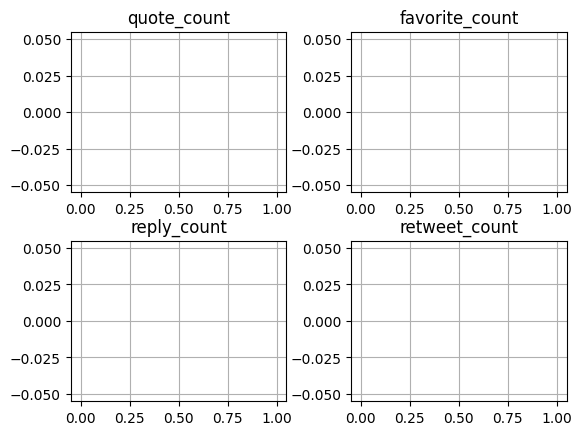

In [74]:
def hist_interaction(df):
    print(df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].describe())
    new_df = df[df['retweet_count'] > 50]
    new_df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].hist()

hist_interaction(df)

        quote_count  favorite_count   reply_count  retweet_count
count  17298.000000    17632.000000  17297.000000   17632.000000
mean       2.174066       35.474705      1.372030      18.285163
std       56.789295      799.756700     35.081692     439.485524
min        0.000000        0.000000      0.000000       0.000000
25%        0.000000        0.000000      0.000000       0.000000
50%        0.000000        0.000000      0.000000       0.000000
75%        0.000000        0.000000      0.000000       0.000000
max     4010.000000    51726.000000   3797.000000   36840.000000


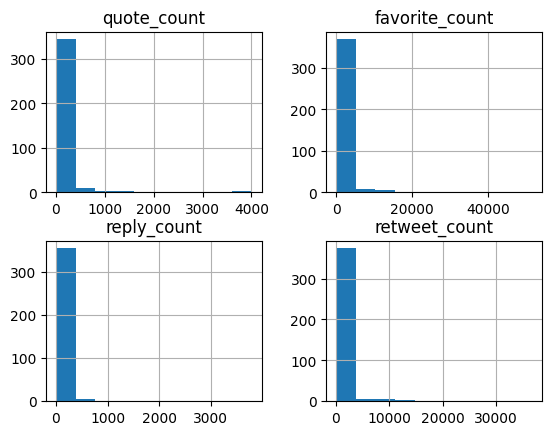

In [75]:
def hist_interaction(df):
    print(df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].describe())
    new_df = df[df['retweet_count'] > 50]
    new_df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].hist()

hist_interaction(df_con_nan)

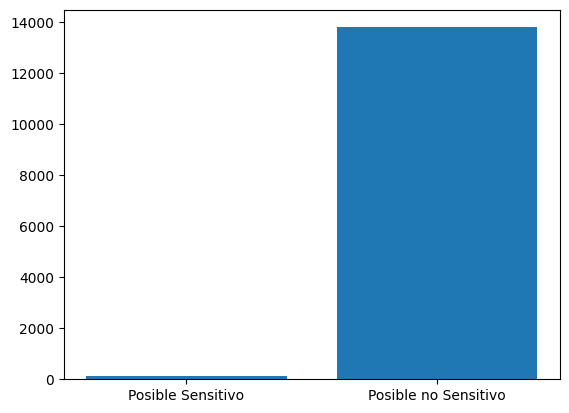

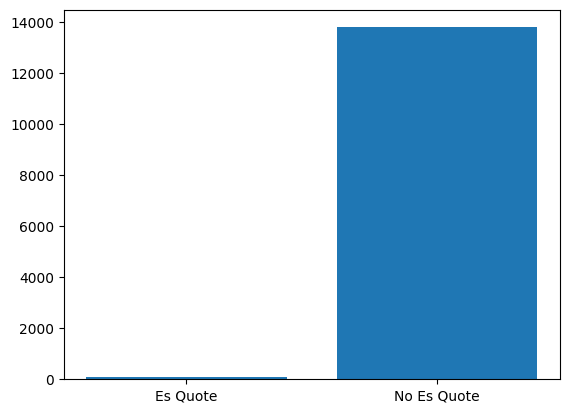

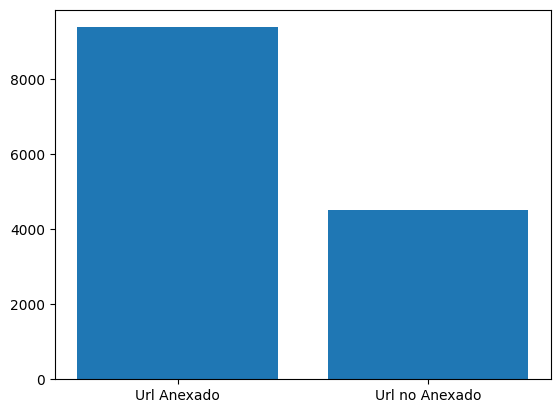

In [76]:
def count_booleans(df):
    valores_T = 0
    valores_F = 0
    quoteable = 0
    not_quotable = 0
    url = 0
    urlnt = 0

    for i in range(df.shape[0]):
        if df["possibly_sensitive"][i]:
            valores_T +=1
        else:
            valores_F +=1

        if df["is_quote_status"][i]:
            quoteable += 1
        else:
            not_quotable += 1        

        if df["entities_urls"][i]:
            url += 1
        else:
            urlnt += 1

    plt.bar(["Posible Sensitivo","Posible no Sensitivo"],[valores_T, valores_F])
    plt.show()

    plt.bar(["Es Quote","No Es Quote"],[quoteable, not_quotable])
    plt.show()

    plt.bar(["Url Anexado","Url no Anexado"],[url, urlnt])
    plt.show()

count_booleans(df)

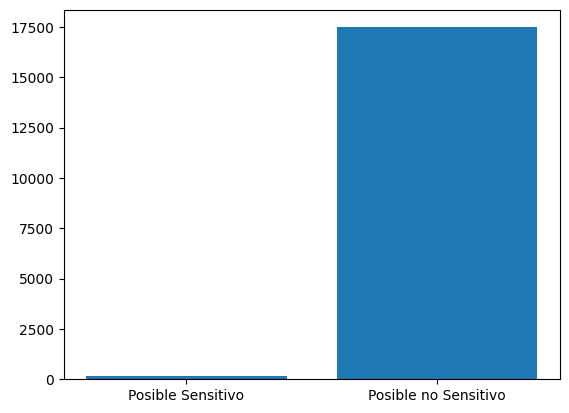

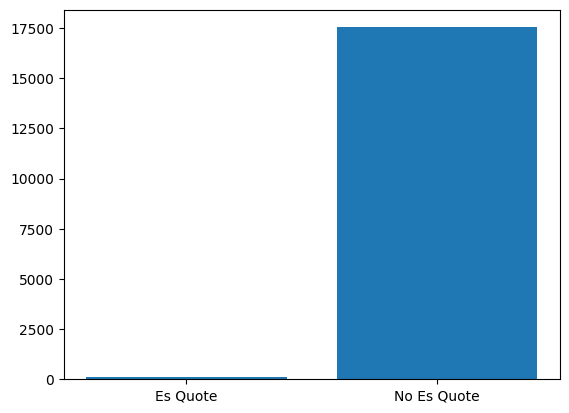

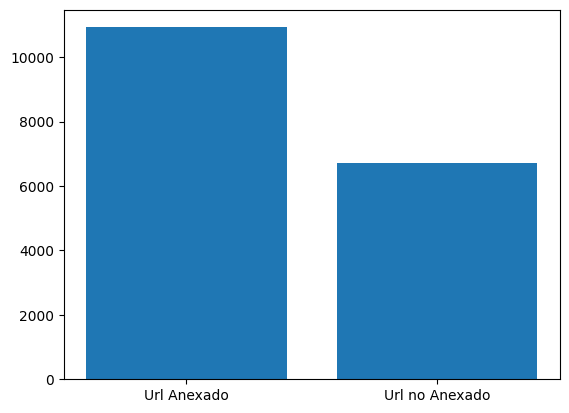

In [77]:
count_booleans(df_con_nan)

Se procede a analizar los tweets si son informativos y si son humanitarios. Se separan en grupos según el valor 'conf'. Si 'conf' es 1, se grafican los valores como tal. Si 'conf' es menor a 1, se gráfica junto al promedio de conf.


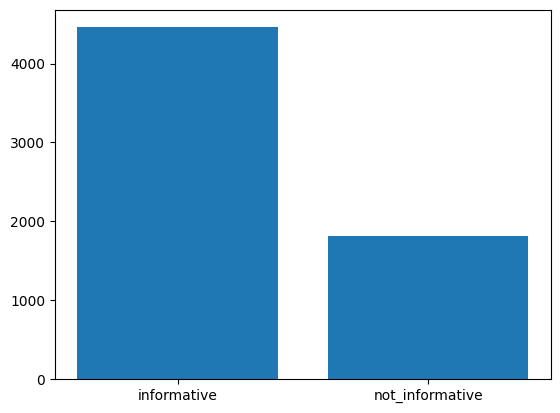

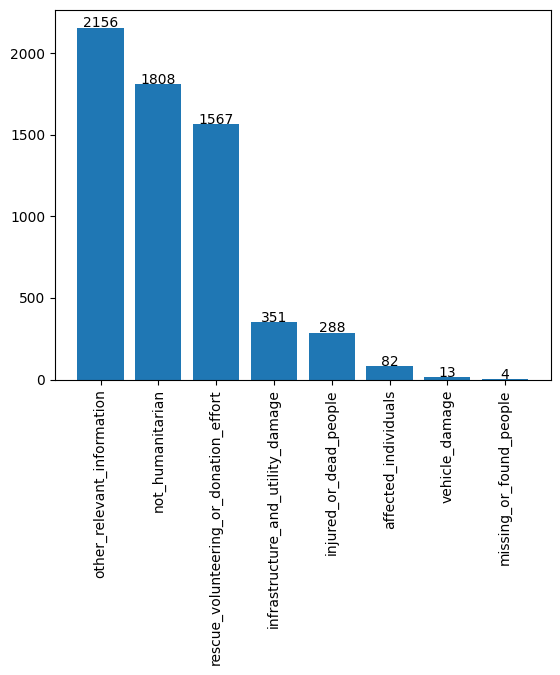

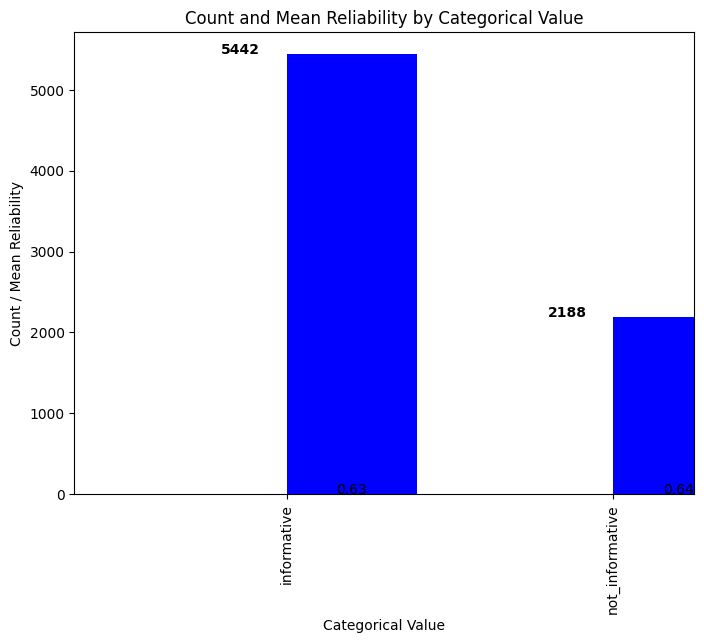

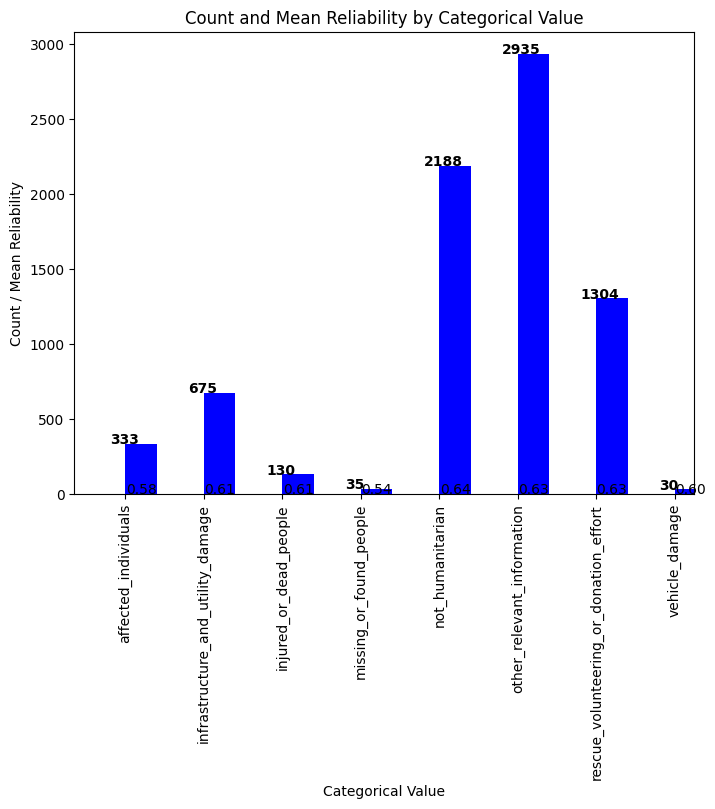

In [78]:
def info_and_human(df):
    
    #se copia la dataframe
    df_info = df.copy()
    df_human = df.copy()

    #se borran los archivos NaN correspondientes
    df_info = df_info[df_info['text_info'].notna()]
    df_info = df_info[df_info['text_info_conf'].notna()]
    df_human = df_human[df_human['text_human'].notna()]
    df_human = df_human[df_human['text_human_conf'].notna()]

    #se reinicia la index si necesario
    df_info.reset_index(inplace=True, drop=True)
    df_human.reset_index(inplace=True, drop=True)

    #se crea nueva id según index
    df_info["new_id"] = df_info.index
    df_human["new_id"] = df_human.index

    
    #se crean dataframes para separar conf=1 con conf<1
    info_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()
    info_casi_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()

    wanted = []
    not_wanted = []

    i = 0
    while i < info_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if info_confiable["text_info_conf"][i] < 1:
            not_wanted.append(info_confiable["new_id"][i])
        else:
            wanted.append(info_confiable["new_id"][i])
        i += 1


    for j in not_wanted:
        info_confiable = info_confiable.drop(info_confiable[info_confiable["new_id"]==j].index)

    for k in wanted:
        info_casi_confiable = info_casi_confiable.drop(info_casi_confiable[info_casi_confiable["new_id"]==k].index)


    #se crean dataframes para separar conf=1 con conf<1
    human_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()
    human_casi_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()

    hwanted = []
    not_hwanted = []

    i = 0
    while i < human_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if human_confiable["text_human_conf"][i] < 1:
            not_hwanted.append(human_confiable["new_id"][i])
        else:
            hwanted.append(human_confiable["new_id"][i])
        i += 1


    for j in not_hwanted:
        human_confiable = human_confiable.drop(human_confiable[human_confiable["new_id"]==j].index)

    for k in hwanted:
        human_casi_confiable = human_casi_confiable.drop(human_casi_confiable[human_casi_confiable["new_id"]==k].index)


    valores_info_confiable = info_confiable["text_info"].value_counts()

    plt.bar(valores_info_confiable.index, valores_info_confiable.values)

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.show()

    valores_human_confiable = human_confiable["text_human"].value_counts()

    plt.bar(valores_human_confiable.index, valores_human_confiable.values)

    for i, v in enumerate(valores_human_confiable.values):
        plt.text(i, v + 1, str(v), ha="center")

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.xticks(rotation=90)

    plt.show()


    # calculate counts and means
    counts = info_casi_confiable['text_info'].value_counts().sort_index()
    means = info_casi_confiable.groupby('text_info')['text_info_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

    # calculate counts and means
    counts = human_casi_confiable['text_human'].value_counts().sort_index()
    means = human_casi_confiable.groupby('text_human')['text_human_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

info_and_human(df)

#### Conteo de palabras

In [79]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

text_data = df['text'].str.split().tolist()
all_words = [word.lower() for sublist in text_data for word in sublist]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
stopwords_en = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stopwords_en]
word_counter = Counter(filtered_words)
top_words = word_counter.most_common(90)  # Puedes ajustar el número de palabras que deseas mostrar


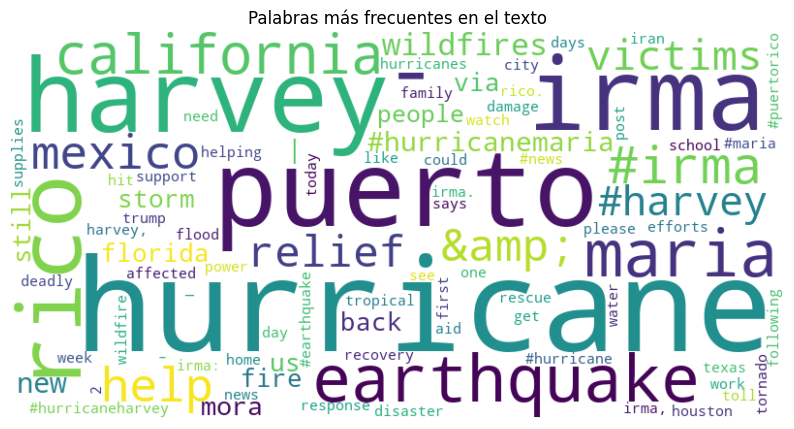

In [81]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes en el texto')
plt.show()


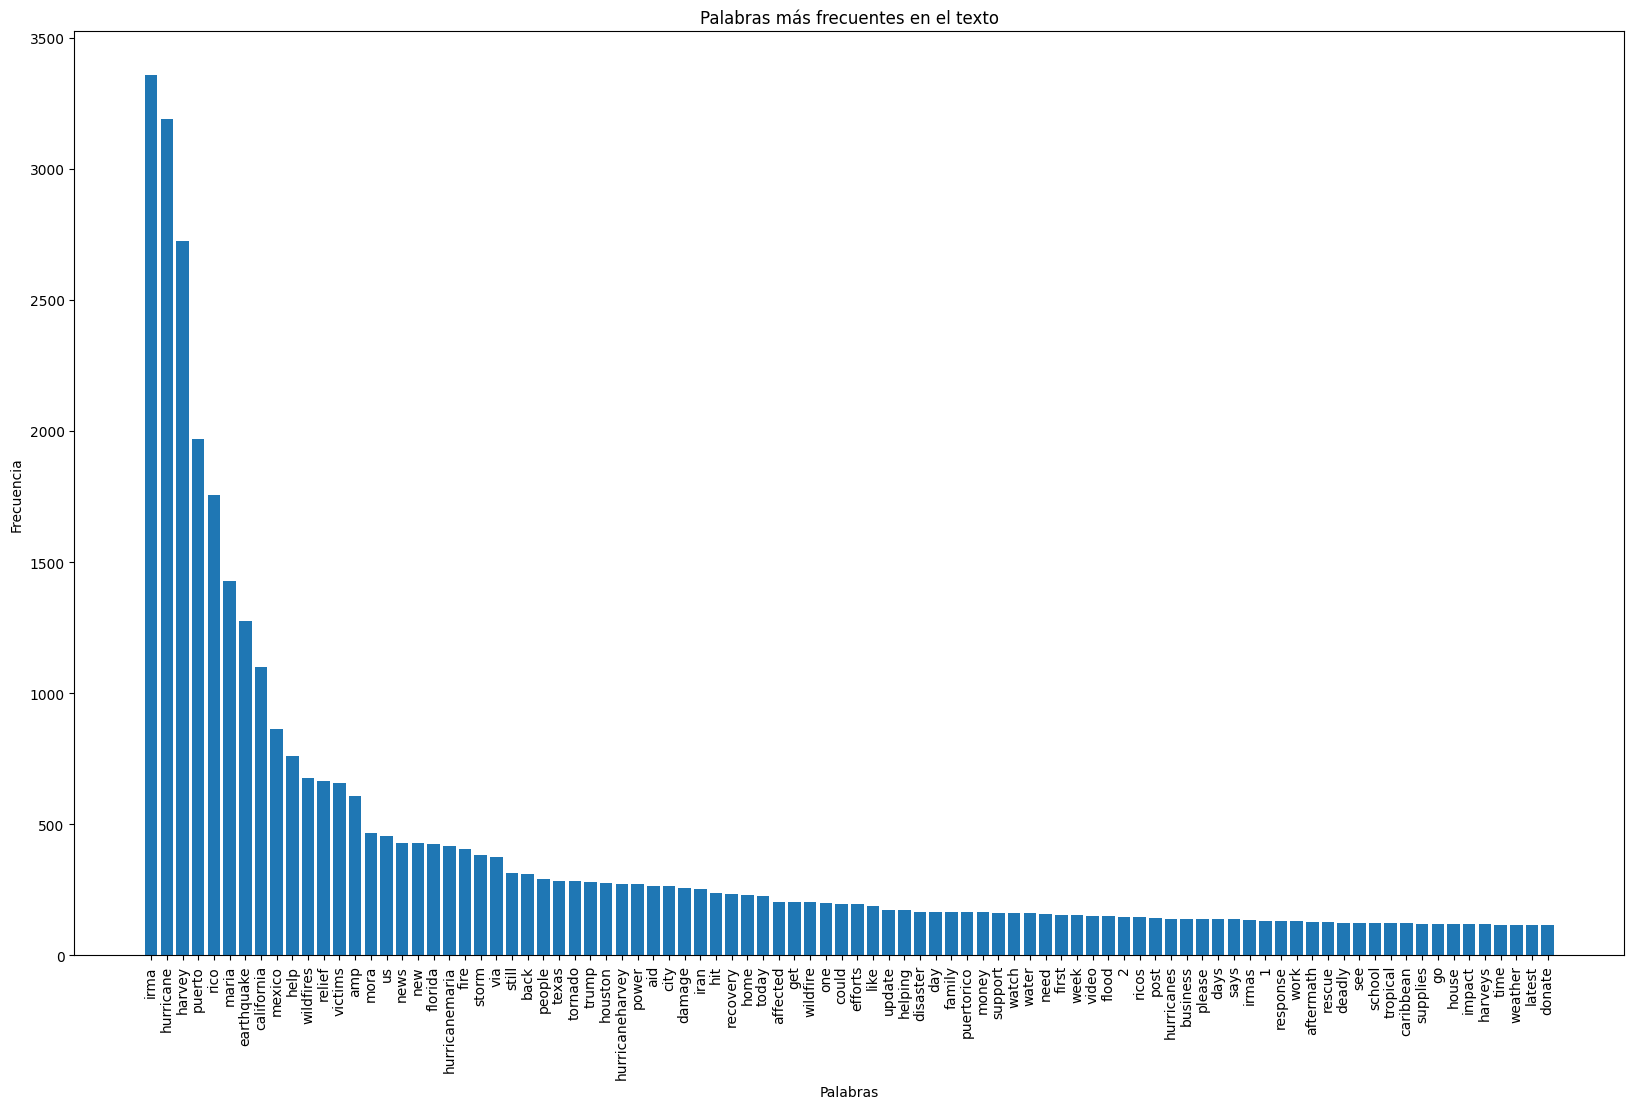

In [82]:

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para limpiar y tokenizar el texto
def clean_and_tokenize(text):
    # Quitar caracteres especiales y símbolos "#" pegados a las palabras
    text = re.sub(r'[^\w\s]|#(?=\w)', '', text)
    # Tokenizar el texto en palabras
    tokens = word_tokenize(text.lower())
    # Quitar las stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Obtener las palabras y sus frecuencias en la columna "text"
words = df['text'].apply(clean_and_tokenize).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()


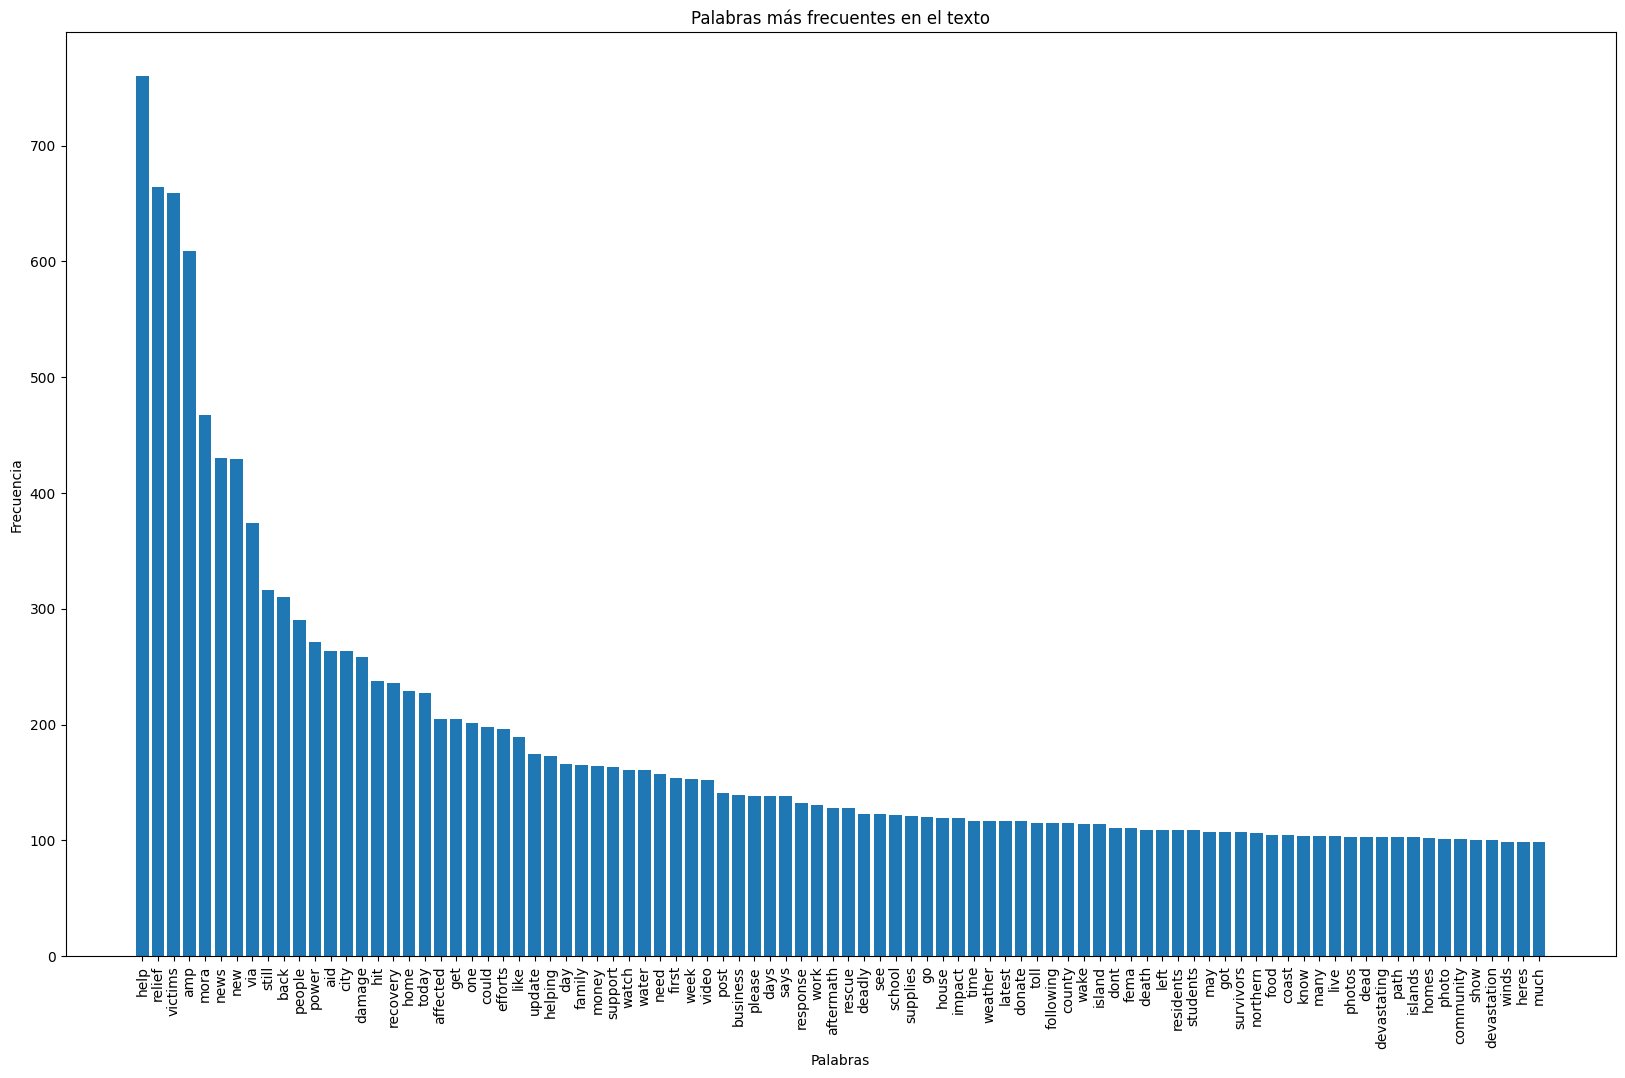

In [83]:

def clean_and_tokenize2(text):
    # Eliminar caracteres especiales y hashtags pegados a palabras
    cleaned_text = re.sub(r"[^\w\s]|(#\w+)", "", text)

    # Tokenizar el texto
    tokens = word_tokenize(cleaned_text.lower())

    # Eliminar stopwords en inglés y palabras adicionales
    stop_words = set(stopwords.words('english'))
    additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
    stop_words.update(additional_stop_words)

    # Agregar números a la lista de stopwords
    stop_words.update(additional_stop_words)
    stop_words.update(set(token for token in tokens if token.isdigit()))

    # Filtrar las palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

# Obtener las palabras y sus frecuencias en la columna "text"
words = df['text'].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

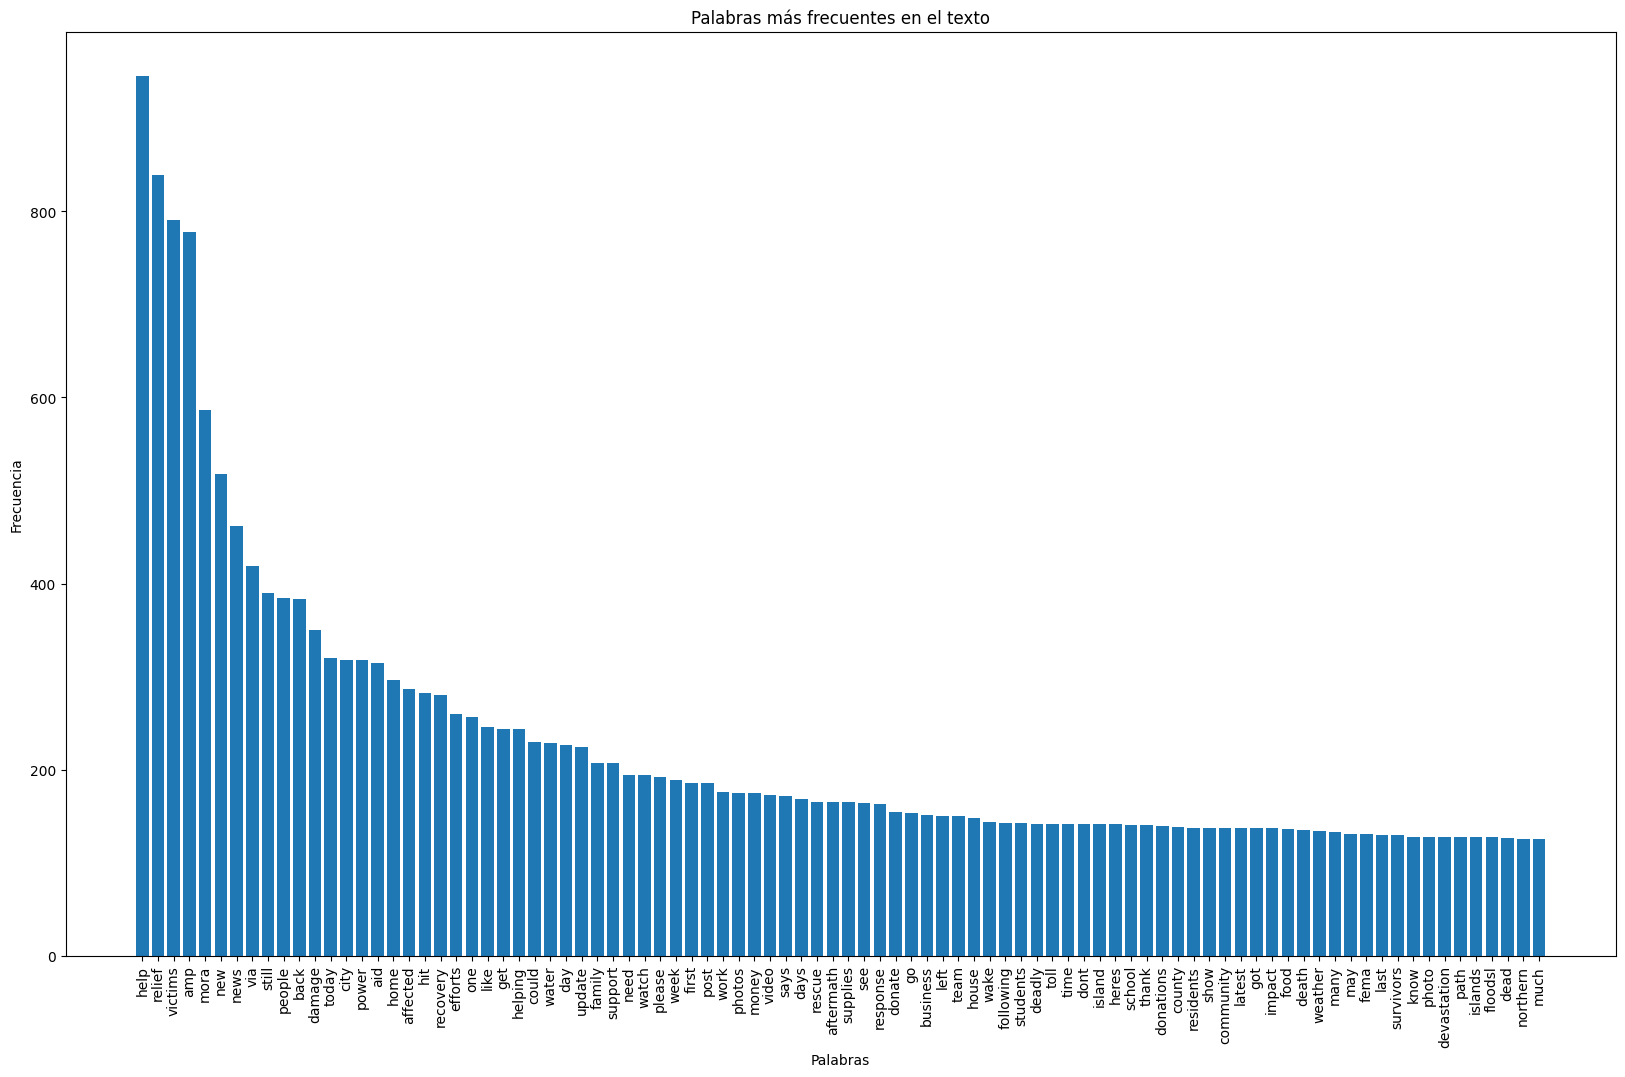

In [90]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df_con_nan['text'].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

### Embeddings

In [84]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopword_tokens
import numpy as np


# Supongamos que tienes una lista de oraciones en la columna de texto
sentences = df["text"].tolist()

stop_words = set(stopwords.words('english'))
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
stop_words.update(additional_stop_words)

# Tokeniza las oraciones y crea una lista de listas de palabras
#tokenized_sentences = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in sentences]


# Definir los parámetros del modelo Word2Vec
vector_size = 100  # Dimensión del espacio vectorial
window_size = 5  # Tamaño de la ventana de contexto
min_count = 1  # Frecuencia mínima de las palabras para ser consideradas

def cargar_embeddings_glove(ruta_archivo):
    embeddings_index = {}
    with open(ruta_archivo, encoding='utf-8') as archivo:
        for linea in archivo:
            valores = linea.split()
            palabra = valores[0]
            vector = np.asarray(valores[1:], dtype='float32')
            embeddings_index[palabra] = vector
    return embeddings_index

ruta_archivo_glove = "glove/glove.6B.200d.txt"  # Reemplaza con la ruta real de tu archivo GloVe
embeddings_glove = cargar_embeddings_glove(ruta_archivo_glove)

# Crear y entrenar el modelo
#model = Word2Vec(tokenized_sentences, vector_size=vector_size, window=window_size, min_count=min_count)

# Obtén el vector de una palabra específica
# word = "help"
# vector = model.wv[word]
# print(f"Vector de '{word}': {vector}")

# Encuentra palabras similares a una palabra dada
# similar_words = model.wv.most_similar(word)
# print(f"Palabras similares a '{word}': {similar_words}")



In [85]:
from sklearn.model_selection import train_test_split

# Carga el dataset en un DataFrame de pandas

# Divide los datos en características (X) y etiquetas (y)
X = df['text'].values  # Reemplaza 'columna_de_texto' con el nombre real de tu columna
y = df['text_human'].values  # Reemplaza 'columna_etiquetas' con el nombre real de tu columna de etiquetas

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
from gensim.utils import simple_preprocess
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np

stop_words = STOP_WORDS
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
stop_words.update(additional_stop_words)

tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)


### Linear SVC

In [87]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)


In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6025179856115108
Precision: 0.5074508838881426
Recall: 0.41840021678199707
F1 Score: 0.4350877586762865


### Analisis de intertacciones

In [7]:
top_favoritos = df_con_nan.sort_values(by=["favorite_count"],ascending=False)
#top_favoritos.head(1)
id = top_favoritos.iloc[4]['id']
print(id)
df_json[df_json["id"]==id]
file_path = "RDATA/CrisisMMD_v2.0/json/hurricane_irma_final_data.json"
datos_json = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        if 'retweeted_status' in data and data['retweeted_status'] != None:
            data = data['retweeted_status']
        datos_json.append(data)

df_old_json = pd.DataFrame(datos_json)
diccionario = df_old_json.iloc[df_old_json.loc[df_old_json['id']==id].index]['extended_entities']

diccionario2 = df_old_json.loc[df_old_json['id']==id,"extended_entities"].tolist()
print(diccionario2)


907017142486401024
[{'media': [{'sizes': {'small': {'w': 680, 'resize': 'fit', 'h': 680}, 'thumb': {'w': 150, 'resize': 'crop', 'h': 150}, 'large': {'w': 742, 'resize': 'fit', 'h': 742}, 'medium': {'w': 742, 'resize': 'fit', 'h': 742}}, 'id': 907017136119468033, 'media_url_https': 'https://pbs.twimg.com/media/DJZfR5uX0AEckgi.jpg', 'media_url': 'http://pbs.twimg.com/media/DJZfR5uX0AEckgi.jpg', 'expanded_url': 'https://twitter.com/basedpaco/status/907017142486401024/photo/1', 'indices': [28, 51], 'id_str': '907017136119468033', 'type': 'photo', 'display_url': 'pic.twitter.com/HHDkPOTruk', 'url': 'https://t.co/HHDkPOTruk'}]}]


#### Grafico de cantidad de tweets por fechas

In [8]:
import matplotlib.dates as mdates
def plot_tweet_distribution_over_time(df, desastre, ax=None):
    if ax is None:
        ax = plt.gca()  # Obtener la subtrama actual si no se proporciona ninguna

    df_disaster = df[df['json_name'] == desastre].copy()
    df_disaster['created_at'] = pd.to_datetime(df_disaster['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
    df_disaster['date'] = df_disaster['created_at'].dt.date

    tweet_count = df_disaster.groupby('date').size()
    tweet_count.plot(ax=ax)

    ax.set_title(f'Tweets por fechas - {desastre}')
    ax.set_xlabel('fecha')
    ax.set_ylabel('Cantidad de tweets')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    plt.xticks(rotation=45)
    plt.tight_layout()


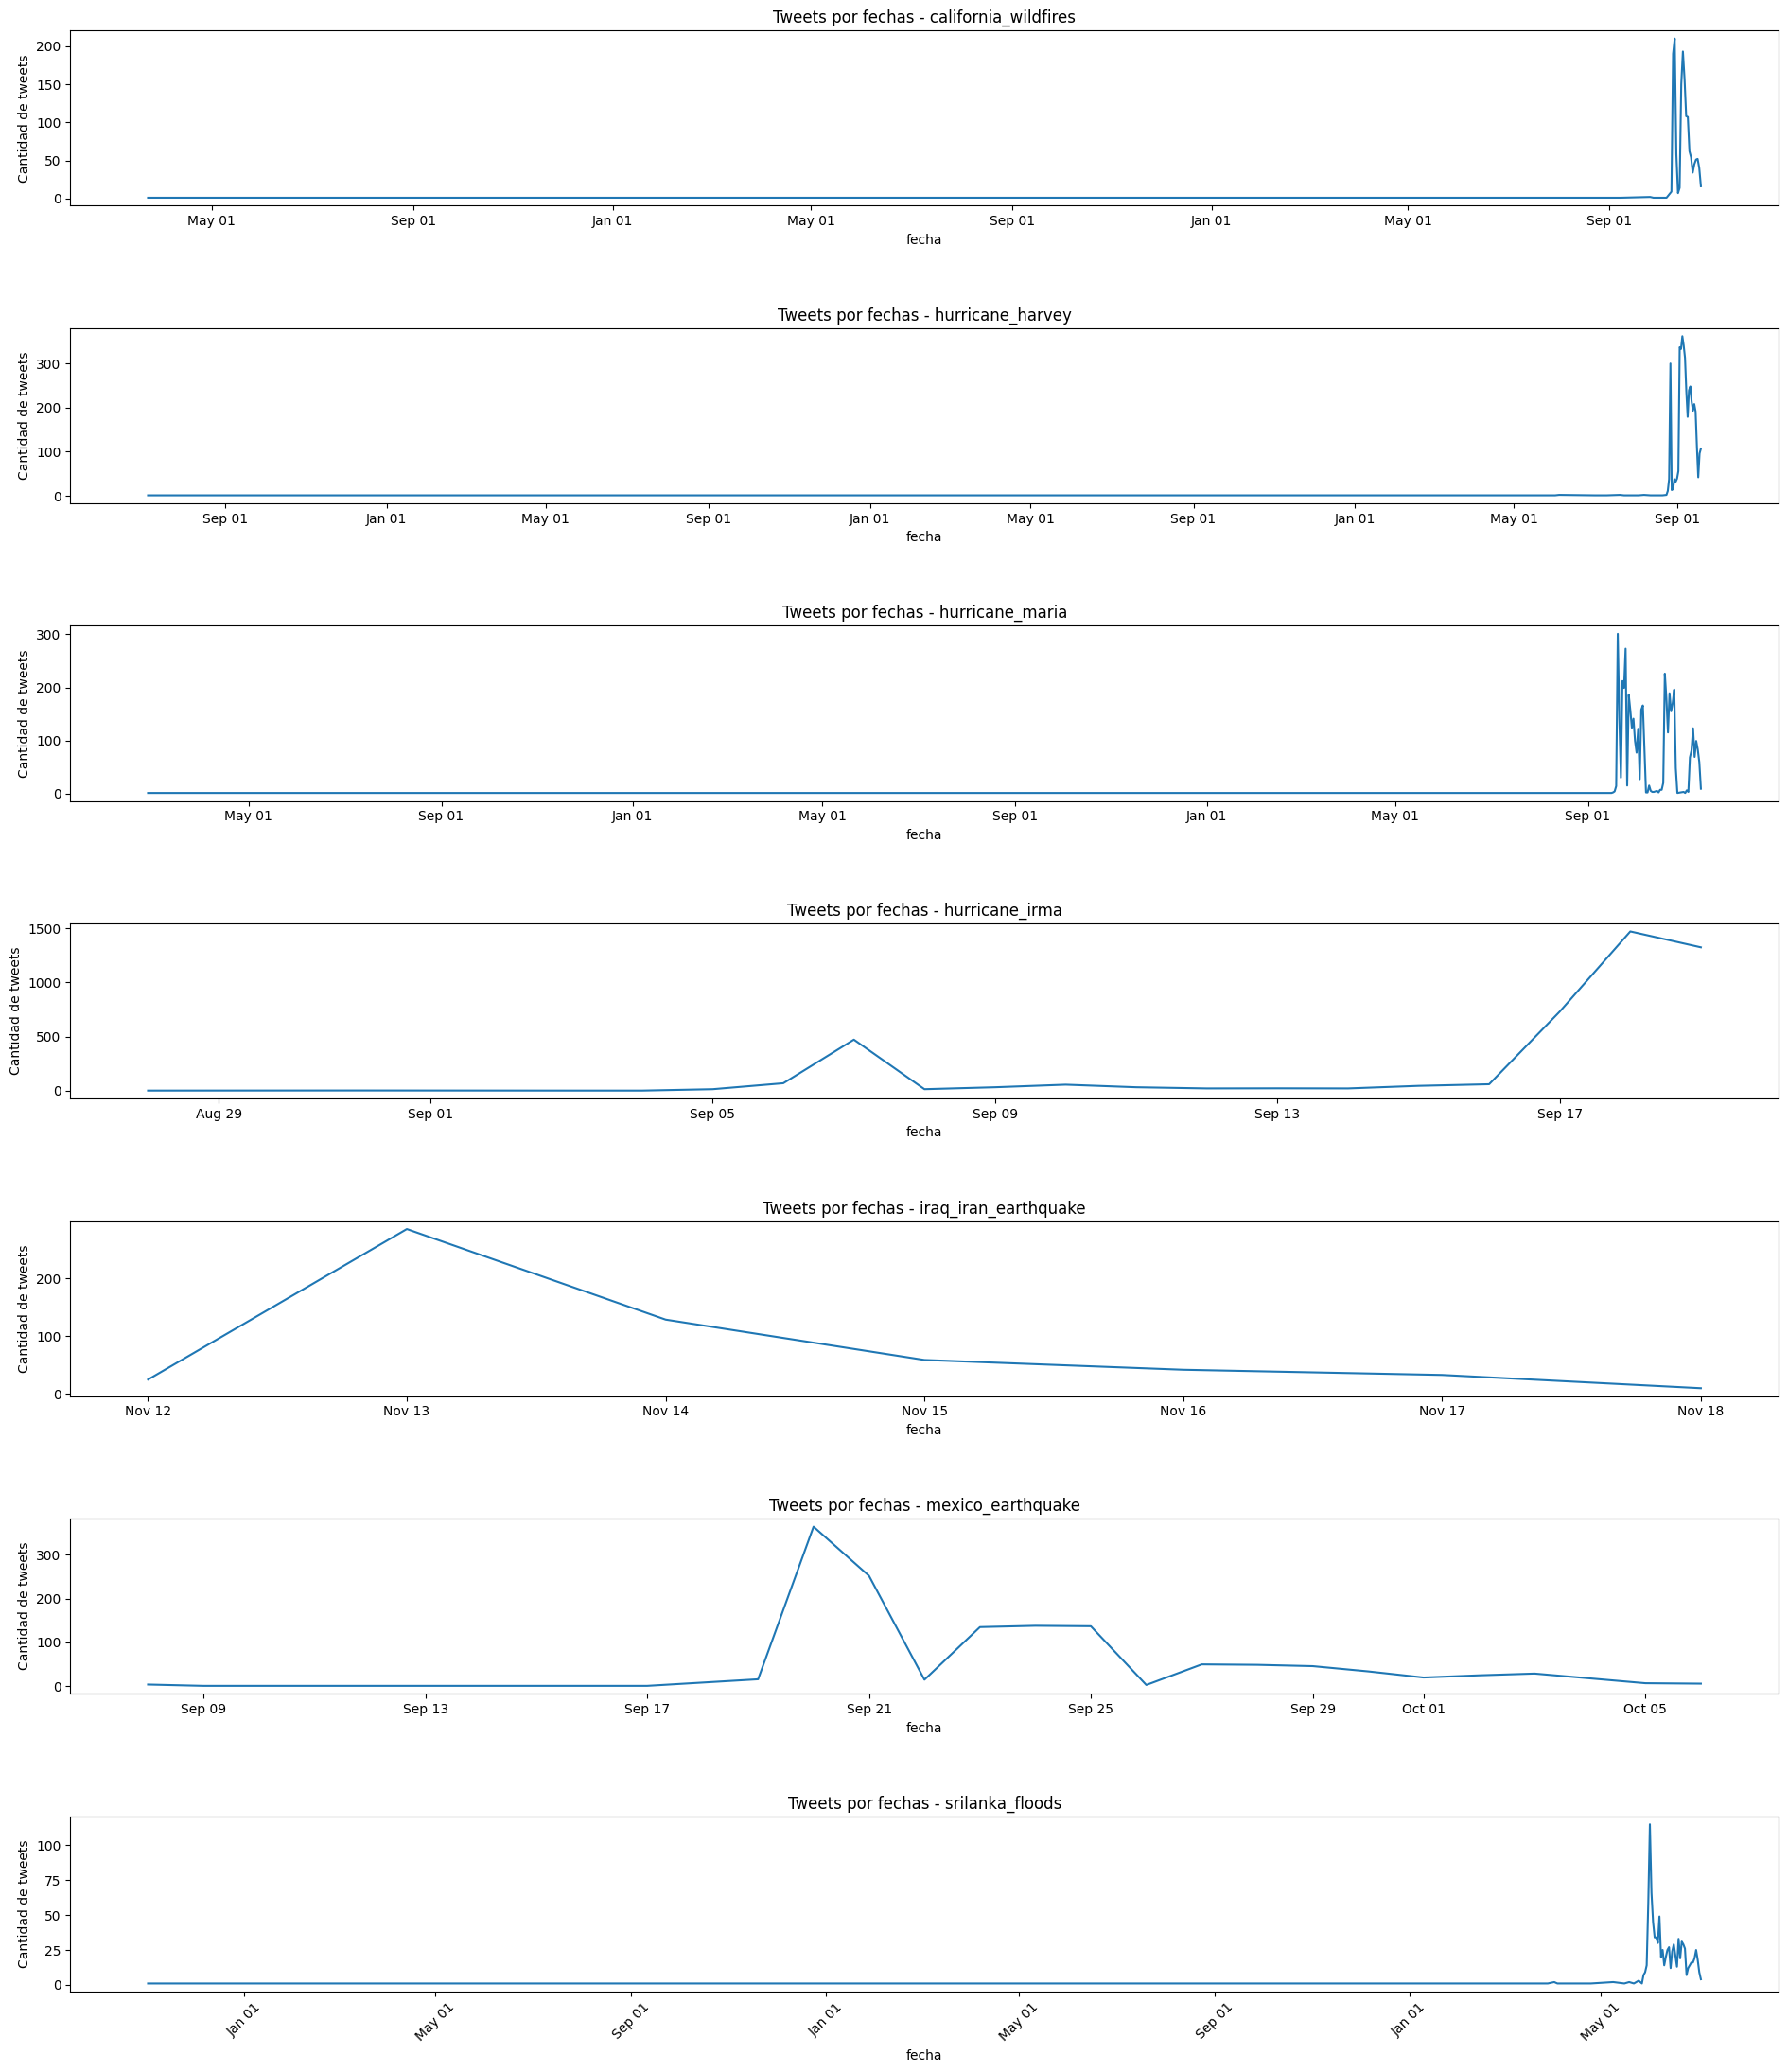

In [9]:
desastres = ['california_wildfires','hurricane_harvey','hurricane_maria','hurricane_irma','iraq_iran_earthquake','mexico_earthquake','srilanka_floods']
fig, axes = plt.subplots(nrows=len(desastres), figsize=(19, 22))

for i, desastre in enumerate(desastres):
    plot_tweet_distribution_over_time(df_con_nan, desastre, ax=axes[i])

plt.subplots_adjust(hspace=0.7)
plt.show()



#### Cosas que me recomendo chatgtp

##### Analizar la cantidad de tweets

In [15]:


tweet_counts = df_con_nan['json_name'].value_counts()
tweet_counts2 =df['json_name'].value_counts()
print(f"Cantidad de tweets con columnas NaN en text_human \n{tweet_counts}")
print()
print(f"Cantidad de tweets sin columnas NaN en text_human\n{tweet_counts2}")

Cantidad de tweets con columnas NaN en text_human 
json_name
hurricane_maria         4423
hurricane_irma          4391
hurricane_harvey        4329
california_wildfires    1569
mexico_earthquake       1337
srilanka_floods          999
iraq_iran_earthquake     584
Name: count, dtype: int64

Cantidad de tweets sin columnas NaN en text_human
json_name
hurricane_maria         3965
hurricane_irma          3780
hurricane_harvey        3652
california_wildfires    1453
mexico_earthquake       1167
srilanka_floods          920
iraq_iran_earthquake     540
Name: count, dtype: int64


##### Analizar las interacciones

In [13]:
interactions = df_con_nan.groupby('json_name')[['retweet_count', 'favorite_count', 'reply_count','quote_count']].mean()
print(f"Promedio de interacciones por desastre \n{interactions}")


Promedio de interacciones por desastre 
                      retweet_count  favorite_count  reply_count  quote_count
json_name                                                                    
california_wildfires       1.873805        2.040153     0.237731     0.189930
hurricane_harvey          25.797875       54.836914     1.994243     1.749687
hurricane_irma            27.974721       54.293100     2.020724     5.058301
hurricane_maria           14.627628       26.034140     1.280353     1.497174
iraq_iran_earthquake       1.986301        1.804795     0.214041     0.195205
mexico_earthquake         12.545999       19.960359     0.547156     1.026178
srilanka_floods            2.318318        3.612613     0.000000     0.000000


In [11]:
# Analizar la ubicación de los usuarios
user_location_counts = df_con_nan['user_location'].value_counts()
print(user_location_counts)

# Analizar hashtags específicos
hashtags_counts = df_con_nan['entities_hashtags_text'].value_counts()
print(hashtags_counts)

# Analizar la presencia de imágenes o enlaces
image_tweets = df_con_nan[df_con_nan['has_image'] == True]
link_tweets = df_con_nan[df_con_nan['entities_urls'] == True]

print(f"Número de tweets con imágenes: {len(image_tweets)}")
print(f"Número de tweets con enlaces: {len(link_tweets)}")


user_location
United States                  349
Washington, DC                 292
New York, NY                   226
Houston, TX                    221
Florida, USA                   209
                              ... 
St. John's, NL                   1
Lancaster, UK                    1
Hemel Hempstead                  1
JFK DUB MAN LHR CDG DXB MEL      1
Chittagong, Bangladesh           1
Name: count, Length: 4342, dtype: int64
entities_hashtags_text
[Irma]                                        310
[Harvey]                                      213
[HurricaneMaria]                              183
[HurricaneHarvey]                             173
[Maria]                                       133
                                             ... 
[NEWSGRAPHIC]                                   1
[storm, irma, hurricaneirma2017, santiago]      1
[Redneck, irma, harvey, Hurricane]              1
[Irma, USVI, PuertoRico, FLwx, FLKeys]          1
[Cameroon, female, Bombers]           

In [16]:
from geopy.geocoders import Nominatim

def get_location_category(location):
    geolocator = Nominatim(user_agent='location_category')
    try:
        location_info = geolocator.geocode(location)
        country = location_info.address.split(',')[-1].strip()
        return country
    except:
        return 'Other'

# Ejemplo de uso
print(get_location_category("St. John's, NL'")) 
print(get_location_category("Florida, USA "))
print(get_location_category("Hemel Hempstead"))  
print(get_location_category("JFK DUB MAN LHR CDG DXB MEL"))  


Canada
United States
United Kingdom
Other


In [13]:
# Agrupar las ubicaciones de los usuarios en categorías más generales
df_con_nan['user_location_general'] = df_con_nan[df_con_nan["json_name"] == "srilanka_floods"]['user_location'].apply(lambda x: get_location_category(x))

# Contar la ocurrencia de cada ubicación general
location_counts = df_con_nan['user_location_general'].value_counts()
print(location_counts)

user_location_general
Italia                267
United States         197
ශ්‍රී ලංකාව இலங்கை    128
Other                  88
United Kingdom         62
                     ... 
ישראל                   1
Ghana                   1
Uruguay                 1
لبنان                   1
Cameroun                1
Name: count, Length: 65, dtype: int64


"\nimport folium\n\n# Crear un mapa centrado en una ubicación inicial\nmap = folium.Map(location=[37.0902, -95.7129], zoom_start=4)\n\n# Marcar las ubicaciones de los tweets en el mapa\nfor index, row in df_con_nan.iterrows():\n    if row['user_location_general'] != '':\n        folium.Marker([row['latitude'], row['longitude']]).add_to(map)\n\n# Mostrar el mapa interactivo\nmap\n"

In [14]:
import folium

# Crear un mapa centrado en una ubicación inicial
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Marcar las ubicaciones de los tweets en el mapa
for index, row in df_con_nan.iterrows():
    if row['user_location_general'] != '':
        folium.Marker([row['latitude'], row['longitude']]).add_to(map)

# Mostrar el mapa interactivo
map

KeyError: 'latitude'

       favorite_count  retweet_count  reply_count  quote_count  magnitud
0                   0              0          0.0          0.0     0.078
1                   7              5          0.0          4.0     0.078
2                 289            479          9.0         25.0     0.078
3                 228            216         19.0         18.0     0.078
4                   0              0          0.0          0.0     0.078
...               ...            ...          ...          ...       ...
17627               0              0          0.0          0.0     0.030
17628               0              0          0.0          0.0     0.030
17629               0              0          0.0          0.0     0.030
17630               0              0          0.0          0.0     0.030
17631               0              1          0.0          0.0     0.030

[17297 rows x 5 columns]


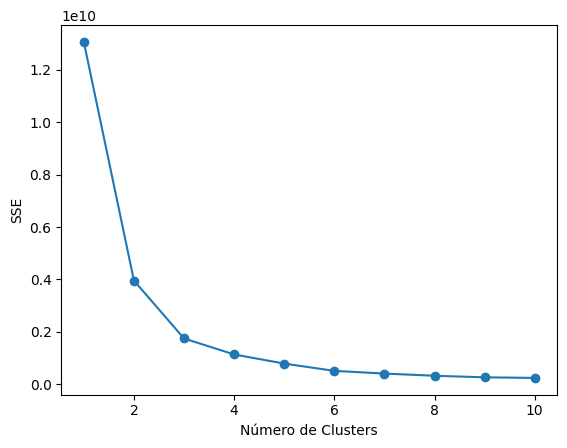

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

mag = {"mexico_earthquake":0.073,
       "hurricane_harvey":0.06,
       "hurricane_irma":0.06,
       "iraq_iran_earthquake":0.107,
       "hurricane_maria":0.046,
       "srilanka_floods":0.03,
       "california_wildfires":0.078}

desastres = ['california_wildfires','hurricane_harvey','hurricane_maria','hurricane_irma','iraq_iran_earthquake','mexico_earthquake','srilanka_floods']



df2 = df_con_nan.copy()
magnitud = []
for row in df2["json_name"]:
    magnitud.append(mag[row])
df2['magnitud'] = magnitud
df2 = df2.select_dtypes(['number'])
df2.drop(["text_human_conf","text_info_conf","id"],axis='columns',inplace=True)

df2 =  df2.dropna()
print(df2)
SSE = []
numClusters = list(range(1, 11))
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
    k_means.fit(df2)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()


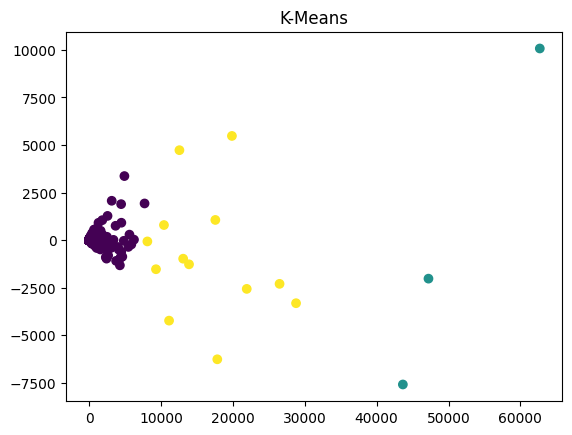

In [50]:
k = 3

from sklearn.decomposition import PCA

'''pca_pre3 = PCA(n_components=3).fit(df2)
df_pca_pre3 = pca_pre3.transform(df2) 

kmeans = KMeans(n_clusters=k, max_iter=50, random_state=1, n_init='auto')
kmeans.fit(df2)



    # Create a figure and a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

    # Plot the data as a 3D scatter plot
ax.scatter3D(df_pca_pre3[:, 0], df_pca_pre3[:, 1], df_pca_pre3[:, 2], c=kmeans.labels_)

    # Set the title and labels
ax.set_title(f"K-Means with {k} clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

    # Show the plot
plt.show()'''

kmeans = KMeans(n_clusters=3, max_iter=50, random_state=1, n_init='auto')
kmeans.fit(df2)
pca = PCA(n_components=2).fit(df2)
df_pca = pca.transform(df2) 

#scatter para cada caso


plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_)
plt.title("K-Means")
plt.show()

In [51]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns=df2.columns)

,favorite_count,retweet_count,reply_count,quote_count,magnitud
0,14.192697,7.827961,0.822406,1.187258,0.058913
1,45792.666667,22862.333333,1807.000000,1157.666667,0.055333
2,14935.692308,6406.153846,315.307692,1047.461538,0.057846


- Grupo 1: Tweets sin mucha relevancia/interacciones
- Grupo 2: Tweets muy 'virales'
- Grupo 3: Tweets con ciertas interacciones